In [1]:
# imports etc.

import sys, os
sys.path.append(os.path.abspath('../'))

from src.utils.flow import *
from src.utils.flow_calculations import *
from src.utils.restoration import *
from src.utils.truncated_packet import *
from src.operations.size_perturbation_logic import *
from src.operations.timing_perturbation_logic import *
from src.operations.calculate_fitness import *

In [2]:
# data preparation

In [3]:
captures = [
    "botnet-capture-20110811-neris",
    "botnet-capture-20110812-rbot",
    "botnet-capture-20110815-fast-flux-2",
    "botnet-capture-20110815-fast-flux",
    "botnet-capture-20110815-rbot-dos",
    "botnet-capture-20110816-donbot",
    "botnet-capture-20110816-qvod",
    "botnet-capture-20110816-sogou",
    "botnet-capture-20110817-bot",
    "botnet-capture-20110818-bot-2",
    "botnet-capture-20110819-bot"
]

In [4]:
import numpy as np

def mean_dicts(dicts):
    keys = set(k for d in dicts for k in d)
    mean_dict = {}
    for key in keys:
        mean_dict[key] = np.mean([d[key] for d in dicts if key in d])
    return mean_dict

def median_dicts(dicts):
    keys = set(k for d in dicts for k in d)
    median_dict = {}
    for key in keys:
        values = [d[key] for d in dicts if key in d]
        median_dict[key] = np.median(values) if values else 0
    return median_dict

def calculate_distance(flow_stats, median_stats):
    return sum((flow_stats[key] - median_stats[key])**2 for key in median_stats)

mean_flows = []
median_flows = []
all_median_flow_packets = []

for i in range(len(captures)):
    print(f'Working on capture: {captures[i]}')

    pcap_file_path = f'../data/raw/filtered/{captures[i]}.pcap'
    model_name = f'{captures[i]}'

    truncated_packets = create_truncated_packets_from_pcap(pcap_file_path)
    print(f"Total packets loaded: {len(truncated_packets)}")

    truncated_packets = assign_flow_ids_to_packets(truncated_packets)

    flow_ids = set(packet.flow_id for packet in truncated_packets)
    flows = []

    for fid in flow_ids:
        sizing_stats = prepare_size_stats(truncated_packets, fid)
        timing_stats = prepare_timing_stats(truncated_packets, fid)
        flow_parameters = {**sizing_stats, **timing_stats}
        flows.append(flow_parameters)
    
    mean_flow_stats = mean_dicts(flows)
    median_flow_stats = median_dicts(flows)
    
    mean_flows.append(mean_flow_stats)
    median_flows.append(median_flow_stats)

    # Find the flow ID that matches the median statistics and has more than 4 packets
    median_flow_ids = set()
    min_distance = float('inf')
    closest_flow_id = None
    
    for fid in flow_ids:
        flow_stats = {**prepare_size_stats(truncated_packets, fid), **prepare_timing_stats(truncated_packets, fid)}
        
        distance = calculate_distance(flow_stats, median_flows[i])
        if distance < min_distance:
            # Check if the flow has more than 4 packets
            flow_packet_count = sum(1 for packet in truncated_packets if packet.flow_id == fid)
            if flow_packet_count > 4:
                min_distance = distance
                closest_flow_id = fid
    
    if closest_flow_id is not None:
        median_flow_ids.add(closest_flow_id)
    
    print(f"Closest median flow ID for capture {captures[i]}: {closest_flow_id}")
    median_flow_packets = [packet for packet in truncated_packets if packet.flow_id in median_flow_ids]
    all_median_flow_packets.append(median_flow_packets)

print("Mean flows calculated:")
print(mean_flows)
print("Median flows calculated:")
print(median_flows)
print("Packets with median flow IDs extracted (organized by capture):")
for i, packets in enumerate(all_median_flow_packets):
    print(f"Capture {captures[i]}: {len(packets)} packets")


Working on capture: botnet-capture-20110811-neris
Total packets loaded: 4955
hash groups: 593
Closest median flow ID for capture botnet-capture-20110811-neris: 28
Working on capture: botnet-capture-20110812-rbot
Total packets loaded: 4958
hash groups: 449
Closest median flow ID for capture botnet-capture-20110812-rbot: 858
Working on capture: botnet-capture-20110815-fast-flux-2
Total packets loaded: 4973
hash groups: 366
Closest median flow ID for capture botnet-capture-20110815-fast-flux-2: 18
Working on capture: botnet-capture-20110815-fast-flux
Total packets loaded: 4968
hash groups: 139
Closest median flow ID for capture botnet-capture-20110815-fast-flux: 123
Working on capture: botnet-capture-20110815-rbot-dos
Total packets loaded: 2653
hash groups: 85
Closest median flow ID for capture botnet-capture-20110815-rbot-dos: 5
Working on capture: botnet-capture-20110816-donbot
Total packets loaded: 4952
hash groups: 657
Closest median flow ID for capture botnet-capture-20110816-donbot:

In [5]:
all_median_flow_packets

[[TruncatedPacket(packet_id=322, timestamp=1313051675.824749, size=62, pseudo_hash='13892256443285734538', flow_id=28, direction='1', src_ip=147.32.84.165, fragmented=0, tcp=1, udp=0, fin=0, syn=1, rst=0, ack=0, psh=0, urg=0),
  TruncatedPacket(packet_id=323, timestamp=1313051675.824968, size=60, pseudo_hash='13892256443285734538', flow_id=28, direction='2', src_ip=147.32.84.218, fragmented=0, tcp=1, udp=0, fin=0, syn=1, rst=0, ack=1, psh=0, urg=0),
  TruncatedPacket(packet_id=324, timestamp=1313051675.825197, size=126, pseudo_hash='13892256443285734538', flow_id=28, direction='1', src_ip=147.32.84.165, fragmented=0, tcp=1, udp=0, fin=0, syn=0, rst=0, ack=1, psh=1, urg=0),
  TruncatedPacket(packet_id=325, timestamp=1313051675.825414, size=60, pseudo_hash='13892256443285734538', flow_id=28, direction='2', src_ip=147.32.84.218, fragmented=0, tcp=1, udp=0, fin=1, syn=0, rst=0, ack=1, psh=0, urg=0),
  TruncatedPacket(packet_id=326, timestamp=1313051675.825647, size=60, pseudo_hash='1389225

In [6]:
# IN ORDER TO PREDICT (FOR TARGET MODEL): predict_single_flow_target(model_name, flow_parameters[0], flow_parametrs[1])

In [7]:
# data testing

In [8]:
    # gen alg

In [9]:
def apply_best_on_packets(packets, max_fitness, flow_id):

    index = max_fitness[1][2]
    if index == 0:
        return packets
    
    params = max_fitness[1][1][index-1] # best technique
    
    if index == 1:     
        return adjust_packet_size(packets, flow_id, params['direction'], 'normal', params['scaling_factor'], params['focus_point'])
                   
    elif index == 2:
        return adjust_packet_size(packets, flow_id, params['direction'], 'uniform', params['scaling_factor'], params['focus_point'])
                
    elif index == 3:
        return apply_time_perturbation_with_focus(packets, flow_id, 'normal', params['focus_point'], params['scaling_factor'])
                
    elif index == 4:
        return apply_time_perturbation_with_focus(packets, flow_id, 'uniform', params['focus_point'], params['scaling_factor'])
        
    return packets

In [10]:
import pygad
import copy

class FlowOptimizer:
    def __init__(self, packets, model_name, flow_id, max_fitness, target):
        self.packets = packets
        self.model_name = model_name
        self.flow_id = flow_id
        self.ga_instance = None
        self.max_fitness = max_fitness
        self.target = target
        
    def apply_best_solution(self):
        best_solution, best_solution_fitness, _ = self.ga_instance.best_solution()
        best_operations = self.decode_operations(best_solution)
        # Stosujemy najlepsze operacje do pakietów
        self.best_modified_packets = self.apply_operations_to_packets(best_operations, self.packets, self.flow_id)
        return self.best_modified_packets, best_solution_fitness

    def on_generation(self, ga_instance):
        pass
            
    def on_fitness(self, ga_instance):
        ga_instance.plot_fitness()

    def fitness_function(self, ga_instance, solution, solution_idx):
        
        fitnesses = []
        target_fitnesses = []
        
        operations = self.decode_operations(solution)
        
        modified_packets = self.packets # always check nop
        sizing_stats = prepare_size_stats(modified_packets, self.flow_id)
        timing_stats = prepare_timing_stats(modified_packets, self.flow_id)
        fitnesses.append(1.0 - predict_single_flow(self.model_name, sizing_stats, timing_stats))
        target_fitnesses.append(1.0 - predict_single_flow_target(self.model_name, sizing_stats, timing_stats))
        
        modified_packets = self.apply_operations_to_packets(operations[0], op_type = 'size_norm')
        sizing_stats = prepare_size_stats(modified_packets, self.flow_id)
        #print(sizing_stats)
        timing_stats = prepare_timing_stats(modified_packets, self.flow_id)
        fitnesses.append(1.0 - predict_single_flow(self.model_name, sizing_stats, timing_stats))
        target_fitnesses.append(1.0 - predict_single_flow_target(self.model_name, sizing_stats, timing_stats))
        
        modified_packets = self.apply_operations_to_packets(operations[1], op_type = 'size_uni')
        sizing_stats = prepare_size_stats(modified_packets, self.flow_id)
        timing_stats = prepare_timing_stats(modified_packets, self.flow_id)
        fitnesses.append(1.0 - predict_single_flow(self.model_name, sizing_stats, timing_stats))
        target_fitnesses.append(1.0 - predict_single_flow_target(self.model_name, sizing_stats, timing_stats))
        
        modified_packets = self.apply_operations_to_packets(operations[2], op_type = 'time_norm')
        sizing_stats = prepare_size_stats(modified_packets, self.flow_id)
        timing_stats = prepare_timing_stats(modified_packets, self.flow_id)
        fitnesses.append(1.0 - predict_single_flow(self.model_name, sizing_stats, timing_stats))
        target_fitnesses.append(1.0 - predict_single_flow_target(self.model_name, sizing_stats, timing_stats))
        
        modified_packets = self.apply_operations_to_packets(operations[3], op_type = 'time_uni')
        sizing_stats = prepare_size_stats(modified_packets, self.flow_id)
        timing_stats = prepare_timing_stats(modified_packets, self.flow_id)
        fitnesses.append(1.0 - predict_single_flow(self.model_name, sizing_stats, timing_stats))
        target_fitnesses.append(1.0 - predict_single_flow_target(self.model_name, sizing_stats, timing_stats))

        if self.target:
            max_fitness_value = max(target_fitnesses)
            max_fitness_index = target_fitnesses.index(max_fitness_value) 

        else:
            max_fitness_value = max(fitnesses) 
            max_fitness_index = fitnesses.index(max_fitness_value) 

        max_fitness_target = target_fitnesses[max_fitness_index]

        #print(self.max_fitness)
        if max_fitness_value > self.max_fitness[0][0]:
            #print(f'CONDITION max: {max_fitness_value}, prev: {self.max_fitness[0]}')
            self.max_fitness = [[max_fitness_value, max_fitness_target], self.decode_operations(solution), max_fitness_index]
            #print(f'self:{self.max_fitness[0]}')
        
        #print(max_fitness_value)
        #print(f'solution:{solution}')
        #print(f'finresses: {fitnesses}, solution:{self.decode_operations(solution)}')
        
        return max_fitness_value

    def optimize_for_flow(self):
        
        #with open(f"progress_for_flow_{self.flow_id}.txt", "w") as file:
        #    file.write("")  # Tylko czyszczenie zawartości pliku
            
        ga_instance = pygad.GA(num_generations=2,
                               num_parents_mating=1,
                               fitness_func=self.fitness_function,
                               sol_per_pop=3,                          
                               mutation_probability=0.7,
                               suppress_warnings= True,
                               on_generation=self.on_generation,
                               num_genes=6, # operations number
                               gene_space = [{'low': 1.1, 'high': 5.0},  # size normal
                                             {'low': 0.25, 'high': 5.0}, # packet size uniform
                                             {'low': 1.1, 'high': 3.0}, # time normal
                                             {'low': 0.4, 'high': 2.4}, # time uniform
                                            [0,1,2],  # direction
                                            [0,1,2]]) # focus point 

        
        ga_instance.run()
        return ga_instance, self.max_fitness

    def decode_operations(self, genotype):
        operations = []
        

        focus_point_map = {0: "start", 1: "middle", 2: "end"}
        focus_point = None
        focus_point_index = genotype[5] 
        focus_point = focus_point_map.get(focus_point_index, None)  

        size_norm = {
            'scaling_factor': genotype[0],
            'direction': genotype[4],
            'focus_point': focus_point
        }
        
        size_uni = {
            'scaling_factor': genotype[1],
            'direction': genotype[4],
            'focus_point': focus_point
        }
        
        time_norm = {
            'scaling_factor': genotype[2],
            'direction': genotype[4],
            'focus_point': focus_point
        }
        
        
        time_uni = {
            'scaling_factor': genotype[3],
            'direction': genotype[4],
            'focus_point': focus_point
        }  
            
            
        
        operations = [size_norm, size_uni, time_norm, time_uni]
        return operations 
        


    def apply_operations_to_packets(self, operation, op_type):


        scaling_factor = operation['scaling_factor']
        direction = operation.get('direction')
        focus_point = operation.get('focus_point')
        

        if op_type == 'size_norm':
            packets = adjust_packet_size_deepcopy(self.packets, self.flow_id, direction, 'normal', scaling_factor, focus_point)
            
            
        elif op_type == 'size_uni':
            packets = adjust_packet_size_deepcopy(self.packets, self.flow_id, direction, 'uniform', scaling_factor, focus_point)
            
        elif op_type == 'time_norm':
            packets = apply_time_perturbation_with_focus_deepcopy(self.packets, self.flow_id, 'normal', focus_point, scaling_factor)
            
        elif op_type == 'time_uni':
            #print(f'przed: {prepare_timing_stats(self.packets, self.flow_id)}')
            packets = apply_time_perturbation_with_focus_deepcopy(self.packets, self.flow_id, 'uniform', focus_point, scaling_factor)
            #print(f'po: {prepare_timing_stats(packets, self.flow_id)}')
            
        #print(packets)
        return packets
    
    


In [11]:
import copy
import os
import pickle


median_attributes = []

def process_flow_id(flow_id, packets, model, target=False):
    print(f"Starting work on flow_id: {flow_id}")
    truncated_packets = copy.deepcopy(packets)  
    inter = []
    max_fitness = [0, [[0, 0], 0, 0], 0]
    previous_max = 0

    attributes = [[], []]
    for i in range(5):
        optimizer = FlowOptimizer(truncated_packets, model, flow_id, max_fitness[1], target)
        max_fitness = optimizer.optimize_for_flow()
        
        if max_fitness[1][0][0] > previous_max:
            truncated_packets = apply_best_on_packets(truncated_packets, max_fitness, flow_id)
            previous_max = max_fitness[1][0][0]
            attributes[0].append(max_fitness[1][2]) # TUTAJ APPEND (op.)
            attributes[1].append(max_fitness[1][1][attributes[0][i]-1]) # APPEND -> direction, scaling factor, focus point (p.)
        else:
            attributes[0].append(-1) 
            attributes[1].append(-1) 
            
    sizing_stats = prepare_size_stats(truncated_packets, flow_id)
    timing_stats = prepare_timing_stats(truncated_packets, flow_id)
    accuracy = predict_single_flow(model_name, sizing_stats, timing_stats)

    return flow_id, attributes, truncated_packets, 1.0 - previous_max # TODO: albo accuracy

def main():

    updated_truncated_packets_list = []


    # FITNESS FUNCTION RF
    for i in range(0, len(captures)):
        print(f'Working on mean flows capture for: {captures[i]}')

        model_name = f'{captures[i]}'

        updated_truncated_packets = all_median_flow_packets[i]

        flow_id, attributes, updated_truncated_packets, accuracy = process_flow_id(all_median_flow_packets[i][0].flow_id, updated_truncated_packets, model_name, target=False) # for this experiment it doesn't really matter if the target is True or False
        median_attributes.append(attributes)

        
        print(f"Completed processing flow for capture {captures[i]}, final results: {attributes}, accuracy: {accuracy}")
        updated_truncated_packets_list.append(updated_truncated_packets)

    #print(median_attributes)


if __name__ == "__main__":
    main()


Working on mean flows capture for: botnet-capture-20110811-neris
Starting work on flow_id: 28
Completed processing flow for capture botnet-capture-20110811-neris, final results: [[4, 2, 2, 2, 2], [{'scaling_factor': 0.40196874838684693, 'direction': 0.0, 'focus_point': 'end'}, {'scaling_factor': 2.355880509456538, 'direction': 0.0, 'focus_point': 'start'}, {'scaling_factor': 4.716711025298529, 'direction': 1.0, 'focus_point': 'end'}, {'scaling_factor': 2.62326128258809, 'direction': 2.0, 'focus_point': 'middle'}, {'scaling_factor': 4.481214983816733, 'direction': 2.0, 'focus_point': 'start'}]], accuracy: 0.8310984413793879
Working on mean flows capture for: botnet-capture-20110812-rbot
Starting work on flow_id: 858
Completed processing flow for capture botnet-capture-20110812-rbot, final results: [[1, 1, 4, 2, 1], [{'scaling_factor': 2.660020869410698, 'direction': 2.0, 'focus_point': 'start'}, {'scaling_factor': 4.8838527673261325, 'direction': 0.0, 'focus_point': 'end'}, {'scaling_fa

In [12]:
    #TODO: funkcja, która na podstawie tej 5-rekordowej listy + mean flow, zastosuje wszystkie operacje i zwróci wynik



In [13]:
median_attributes

[[[4, 2, 2, 2, 2],
  [{'scaling_factor': 0.40196874838684693,
    'direction': 0.0,
    'focus_point': 'end'},
   {'scaling_factor': 2.355880509456538,
    'direction': 0.0,
    'focus_point': 'start'},
   {'scaling_factor': 4.716711025298529,
    'direction': 1.0,
    'focus_point': 'end'},
   {'scaling_factor': 2.62326128258809,
    'direction': 2.0,
    'focus_point': 'middle'},
   {'scaling_factor': 4.481214983816733,
    'direction': 2.0,
    'focus_point': 'start'}]],
 [[1, 1, 4, 2, 1],
  [{'scaling_factor': 2.660020869410698,
    'direction': 2.0,
    'focus_point': 'start'},
   {'scaling_factor': 4.8838527673261325,
    'direction': 0.0,
    'focus_point': 'end'},
   {'scaling_factor': 2.313992659372034,
    'direction': 2.0,
    'focus_point': 'end'},
   {'scaling_factor': 4.672682024888384,
    'direction': 0.0,
    'focus_point': 'middle'},
   {'scaling_factor': 1.8241029276897822,
    'direction': 1.0,
    'focus_point': 'end'}]],
 [[3, 3, 2, 2, 2],
  [{'scaling_factor': 1.

In [14]:
all_median_flow_packets

[[TruncatedPacket(packet_id=322, timestamp=1313051675.824749, size=62, pseudo_hash='13892256443285734538', flow_id=28, direction='1', src_ip=147.32.84.165, fragmented=0, tcp=1, udp=0, fin=0, syn=1, rst=0, ack=0, psh=0, urg=0),
  TruncatedPacket(packet_id=323, timestamp=1313051675.824968, size=60, pseudo_hash='13892256443285734538', flow_id=28, direction='2', src_ip=147.32.84.218, fragmented=0, tcp=1, udp=0, fin=0, syn=1, rst=0, ack=1, psh=0, urg=0),
  TruncatedPacket(packet_id=324, timestamp=1313051675.825197, size=126, pseudo_hash='13892256443285734538', flow_id=28, direction='1', src_ip=147.32.84.165, fragmented=0, tcp=1, udp=0, fin=0, syn=0, rst=0, ack=1, psh=1, urg=0),
  TruncatedPacket(packet_id=325, timestamp=1313051675.825414, size=60, pseudo_hash='13892256443285734538', flow_id=28, direction='2', src_ip=147.32.84.218, fragmented=0, tcp=1, udp=0, fin=1, syn=0, rst=0, ack=1, psh=0, urg=0),
  TruncatedPacket(packet_id=326, timestamp=1313051675.825647, size=60, pseudo_hash='1389225

In [15]:
def apply_best_on_packets_xai(packets, attributes, flow_id):
    for i in range(5):
        index = attributes[0][i]
        if index == 0 or index == -1:
            return packets
        
        params = attributes[1][i]
        
        if index == 1:     
            packets = adjust_packet_size(packets, flow_id, params['direction'], 'normal', params['scaling_factor'], params['focus_point'])
                   
        elif index == 2:
            packets = adjust_packet_size(packets, flow_id, params['direction'], 'uniform', params['scaling_factor'], params['focus_point'])
                
        elif index == 3:
            packets = apply_time_perturbation_with_focus(packets, flow_id, 'normal', params['focus_point'], params['scaling_factor'])
                
        elif index == 4:
            packets = apply_time_perturbation_with_focus(packets, flow_id, 'uniform', params['focus_point'], params['scaling_factor'])

        # Debugging: Print the packet state after each operation
        #print(f"After operation {i+1}: {packets}")
        #print("\n")
        
    return packets

def apply_attributes(median_attributes, packet_set, model_name):
    total_accuracy = 0.0
    median_attr = median_attributes
    flow_id = packet_set[0].flow_id if packet_set else None
    packets = apply_best_on_packets_xai(packet_set, median_attr, flow_id)
    sizing_stats = prepare_size_stats(packets, flow_id)
    timing_stats = prepare_timing_stats(packets, flow_id)
    accuracy = predict_single_flow(model_name, sizing_stats, timing_stats)

    # Debugging: Print the stats and accuracy
    #print(f"sizing stats: {sizing_stats}, timing stats: {timing_stats}, accuracy: {accuracy}")

    return accuracy


# Example usage
for i in range(0, len(captures)):
    print(f'Working on mean flows capture for: {captures[i]}')

    model_name = f'{captures[i]}'

    all_median_flow_packets_copy = copy.deepcopy(all_median_flow_packets) 
    

    accuracy = apply_attributes(median_attributes[i], all_median_flow_packets_copy[i], model_name)
    print(f"Overall accuracy: {accuracy}")


Working on mean flows capture for: botnet-capture-20110811-neris
Overall accuracy: 0.8310984413793879
Working on mean flows capture for: botnet-capture-20110812-rbot
Overall accuracy: 0.6183593741632872
Working on mean flows capture for: botnet-capture-20110815-fast-flux-2
Overall accuracy: 0.8336020598927536
Working on mean flows capture for: botnet-capture-20110815-fast-flux
Overall accuracy: 0.4662352809238541
Working on mean flows capture for: botnet-capture-20110815-rbot-dos
Overall accuracy: 0.45740291792778237
Working on mean flows capture for: botnet-capture-20110816-donbot
Overall accuracy: 0.5580012181589099
Working on mean flows capture for: botnet-capture-20110816-qvod
Overall accuracy: 0.48515256906380594
Working on mean flows capture for: botnet-capture-20110816-sogou
Overall accuracy: 0.43469104402707515
Working on mean flows capture for: botnet-capture-20110817-bot
Overall accuracy: 0.8843365571292178
Working on mean flows capture for: botnet-capture-20110818-bot-2
Over

In [16]:
# xai preparation & perturbation functions

import pandas as pd

def transform_attributes_to_df(median_attributes):
    columns = [
        "operation_1", "scaling_factor_1", "direction_1", "focus_point_1",
        "operation_2", "scaling_factor_2", "direction_2", "focus_point_2",
        "operation_3", "scaling_factor_3", "direction_3", "focus_point_3",
        "operation_4", "scaling_factor_4", "direction_4", "focus_point_4",
        "operation_5", "scaling_factor_5", "direction_5", "focus_point_5"
    ]
    
    data = []
    
    for attrs in median_attributes:
        row = []
        operations, params = attrs
        
        for i in range(5):
            row.append(operations[i])
            if params[i] == -1:
                row.extend([-1, -1, -1])
            else:
                row.append(params[i]['scaling_factor'])
                row.append(params[i]['direction'])
                row.append(params[i]['focus_point'])
        
        data.append(row)
    
    df = pd.DataFrame(data, columns=columns)
    return df

transform_attributes_to_df(median_attributes)

,operation_1,scaling_factor_1,direction_1,focus_point_1,operation_2,scaling_factor_2,direction_2,focus_point_2,operation_3,scaling_factor_3,direction_3,focus_point_3,operation_4,scaling_factor_4,direction_4,focus_point_4,operation_5,scaling_factor_5,direction_5,focus_point_5
0,4,0.401969,0.0,end,2,2.355881,0.0,start,2,4.716711,1.0,end,2,2.623261,2.0,middle,2,4.481215,2.0,start
1,1,2.660021,2.0,start,1,4.883853,0.0,end,4,2.313993,2.0,end,2,4.672682,0.0,middle,1,1.824103,1.0,end
2,3,1.711389,2.0,start,3,2.155966,0.0,end,2,2.803211,0.0,end,2,4.760720,0.0,end,2,2.001414,1.0,start
3,4,2.145503,0.0,middle,2,4.346575,0.0,middle,4,2.130952,2.0,middle,4,1.861892,1.0,start,4,2.272936,2.0,middle
4,2,4.873704,0.0,middle,4,2.363568,2.0,start,1,1.970434,1.0,start,2,1.972568,0.0,start,-1,-1.000000,-1.0,-1
5,2,2.320474,0.0,middle,2,3.698309,0.0,middle,2,4.469146,0.0,middle,4,1.151069,2.0,start,2,0.406749,2.0,end
6,2,4.694457,0.0,middle,2,4.915376,1.0,middle,4,2.304380,2.0,start,1,4.952440,0.0,end,4,2.129487,0.0,middle
7,2,2.715986,0.0,end,2,0.298502,2.0,middle,1,2.975286,2.0,start,2,3.936186,1.0,end,2,4.474628,1.0,end
8,2,4.416847,0.0,end,2,3.766668,0.0,middle,3,2.420158,0.0,middle,3,1.917994,0.0,end,2,3.529686,1.0,start
9,4,2.382743,1.0,start,2,1.927263,0.0,middle,2,4.119364,1.0,end,2,3.671523,1.0,end,4,2.314637,2.0,end


In [17]:
def df_to_median_attributes(df):
    median_attributes = []
    for _, row in df.iterrows():
        operations = [
            row["operation_1"], row["operation_2"], row["operation_3"],
            row["operation_4"], row["operation_5"]
        ]
        params = []
        for i in range(1, 6):
            if row[f"operation_{i}"] == -1:
                params.append(-1)
            else:
                param = {
                    "scaling_factor": row[f"scaling_factor_{i}"],
                    "direction": row[f"direction_{i}"],
                    "focus_point": row[f"focus_point_{i}"]
                }
                params.append(param)
        median_attributes.append([operations, params])
    return median_attributes

median_attributes == df_to_median_attributes(transform_attributes_to_df(median_attributes))

True

In [18]:
#!pip install shap

In [19]:
df = transform_attributes_to_df(median_attributes)

In [20]:
# filtering out operations columns, because they shouldn't be included in shap analysis

df_filtered = df.drop(columns=["operation_1", "operation_2", "operation_3", "operation_4", "operation_5"])
df_operations = df[["operation_1", "operation_2", "operation_3", "operation_4", "operation_5"]]

In [21]:
from sklearn.preprocessing import OneHotEncoder

def encode_focus_points(df, focus_point_columns):
    encoded_df = df.copy()
    encoders = {}
    
    for column in focus_point_columns:
        encoder = OneHotEncoder(sparse=False)
        encoded_df[column] = encoded_df[column].astype(str)  # Ensure all values are strings
        encoded_values = encoder.fit_transform(encoded_df[[column]])
        encoders[column] = encoder
        encoded_df = encoded_df.drop(column, axis=1)
        for i, category in enumerate(encoder.categories_[0]):
            encoded_df[f"{column}_{category}"] = encoded_values[:, i]
            
    return encoded_df, encoders

focus_point_columns = ["focus_point_1", "focus_point_2", "focus_point_3", "focus_point_4", "focus_point_5"]
encoded_df, encoders = encode_focus_points(df_filtered, focus_point_columns)
encoded_df


/home/user/miniconda3/envs/cyberaml/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/user/miniconda3/envs/cyberaml/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/user/miniconda3/envs/cyberaml/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/user/miniconda3/envs/cyberaml/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarn

,scaling_factor_1,direction_1,scaling_factor_2,direction_2,scaling_factor_3,direction_3,scaling_factor_4,direction_4,scaling_factor_5,direction_5,...,focus_point_3_middle,focus_point_3_start,focus_point_4_-1,focus_point_4_end,focus_point_4_middle,focus_point_4_start,focus_point_5_-1,focus_point_5_end,focus_point_5_middle,focus_point_5_start
0,0.401969,0.0,2.355881,0.0,4.716711,1.0,2.623261,2.0,4.481215,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,2.660021,2.0,4.883853,0.0,2.313993,2.0,4.672682,0.0,1.824103,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1.711389,2.0,2.155966,0.0,2.803211,0.0,4.760720,0.0,2.001414,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2.145503,0.0,4.346575,0.0,2.130952,2.0,1.861892,1.0,2.272936,2.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,4.873704,0.0,2.363568,2.0,1.970434,1.0,1.972568,0.0,-1.000000,-1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
5,2.320474,0.0,3.698309,0.0,4.469146,0.0,1.151069,2.0,0.406749,2.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
6,4.694457,0.0,4.915376,1.0,2.304380,2.0,4.952440,0.0,2.129487,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
7,2.715986,0.0,0.298502,2.0,2.975286,2.0,3.936186,1.0,4.474628,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
8,4.416847,0.0,3.766668,0.0,2.420158,0.0,1.917994,0.0,3.529686,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
9,2.382743,1.0,1.927263,0.0,4.119364,1.0,3.671523,1.0,2.314637,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [22]:
import pandas as pd
import numpy as np

def reverse_encode_focus_points(encoded_values, column_names, focus_point_columns, encoders):
    # Create DataFrame from the values and column names
    encoded_df = pd.DataFrame(encoded_values, columns=column_names)
    decoded_df = encoded_df.copy()
    
    #print("Encoded DataFrame:")
    #print(encoded_df.head())

    for column in focus_point_columns:
        encoder = encoders[column]
        # Extract the columns related to this focus point
        related_cols = [col for col in encoded_df.columns if col.startswith(column)]
        
        #print(f"Processing column: {column}")
        #print(f"Related columns: {related_cols}")
        
        if related_cols:
            # Find the column with the max value for each row (one-hot encoding)
            max_col_indices = encoded_df[related_cols].values.argmax(axis=1)
            categories = encoder.categories_[0]
            
            # Ensure the indices are within the range of the categories
            decoded_values = [categories[idx] if idx < len(categories) else 'unknown' for idx in max_col_indices]
            
            #print(f"Max column indices for {column}: {max_col_indices}")
            #print(f"Decoded values for {column}: {decoded_values}")
            
            decoded_df[column] = decoded_values
            # Drop the one-hot encoded columns
            # decoded_df = decoded_df.drop(columns=related_cols)
        else:
            decoded_df[column] = -1
    
    #print("Decoded DataFrame:")
    #print(decoded_df.head())

    return decoded_df



# Example usage
reverse_encode_focus_points(encoded_df.values, encoded_df.columns, focus_point_columns, encoders)


,scaling_factor_1,direction_1,scaling_factor_2,direction_2,scaling_factor_3,direction_3,scaling_factor_4,direction_4,scaling_factor_5,direction_5,...,focus_point_4_start,focus_point_5_-1,focus_point_5_end,focus_point_5_middle,focus_point_5_start,focus_point_1,focus_point_2,focus_point_3,focus_point_4,focus_point_5
0,0.401969,0.0,2.355881,0.0,4.716711,1.0,2.623261,2.0,4.481215,2.0,...,0.0,0.0,0.0,0.0,1.0,end,start,end,middle,start
1,2.660021,2.0,4.883853,0.0,2.313993,2.0,4.672682,0.0,1.824103,1.0,...,0.0,0.0,1.0,0.0,0.0,start,end,end,middle,end
2,1.711389,2.0,2.155966,0.0,2.803211,0.0,4.760720,0.0,2.001414,1.0,...,0.0,0.0,0.0,0.0,1.0,start,end,end,end,start
3,2.145503,0.0,4.346575,0.0,2.130952,2.0,1.861892,1.0,2.272936,2.0,...,1.0,0.0,0.0,1.0,0.0,middle,middle,middle,start,middle
4,4.873704,0.0,2.363568,2.0,1.970434,1.0,1.972568,0.0,-1.000000,-1.0,...,1.0,1.0,0.0,0.0,0.0,middle,start,start,start,-1
5,2.320474,0.0,3.698309,0.0,4.469146,0.0,1.151069,2.0,0.406749,2.0,...,1.0,0.0,1.0,0.0,0.0,middle,middle,middle,start,end
6,4.694457,0.0,4.915376,1.0,2.304380,2.0,4.952440,0.0,2.129487,0.0,...,0.0,0.0,0.0,1.0,0.0,middle,middle,start,end,middle
7,2.715986,0.0,0.298502,2.0,2.975286,2.0,3.936186,1.0,4.474628,1.0,...,0.0,0.0,1.0,0.0,0.0,end,middle,start,end,end
8,4.416847,0.0,3.766668,0.0,2.420158,0.0,1.917994,0.0,3.529686,1.0,...,0.0,0.0,0.0,0.0,1.0,end,middle,middle,end,start
9,2.382743,1.0,1.927263,0.0,4.119364,1.0,3.671523,1.0,2.314637,2.0,...,0.0,0.0,1.0,0.0,0.0,start,middle,end,end,end


In [23]:
encoders

{'focus_point_1': OneHotEncoder(sparse=False, sparse_output=False),
 'focus_point_2': OneHotEncoder(sparse=False, sparse_output=False),
 'focus_point_3': OneHotEncoder(sparse=False, sparse_output=False),
 'focus_point_4': OneHotEncoder(sparse=False, sparse_output=False),
 'focus_point_5': OneHotEncoder(sparse=False, sparse_output=False)}

In [24]:
X = encoded_df.iloc[[1]]

In [25]:
columns= X.columns

In [63]:
# TODO: ten predict przestal dzialac prawidlowo po rozdzieleniu columns od values

def predict(xai_df, i, columns = columns): 
    xai_df = reverse_encode_focus_points(xai_df, columns, focus_point_columns, encoders)
    #xai_df = xai_df.iloc[[i]] #outside shap
    full_df = pd.concat([xai_df.set_index(df_operations.iloc[[i]].index), df_operations.iloc[[i]]], axis=1)
    #print(f"[DEBUGGGG] xat {xai_df}\n op{df_operations.iloc[[i]]}\n full{full_df} ")
    median_attributes = df_to_median_attributes(full_df)
    all_median_flow_packets_copy = copy.deepcopy(all_median_flow_packets[i])
    model_name = f"{captures[i]}"
    #print(f"[DEBUG] {median_attributes}")
    accuracy = apply_attributes(median_attributes[0], all_median_flow_packets_copy, model_name) # always zero because only one case

    #return np.column_stack((accuracy, 1.0 - accuracy))
    #return np.array([[accuracy, 1.0 - accuracy]])
    return (1.0 - accuracy)

In [27]:
df_operations.iloc[[0]]

,operation_1,operation_2,operation_3,operation_4,operation_5
0,4,2,2,2,2


In [28]:
encoded_df

,scaling_factor_1,direction_1,scaling_factor_2,direction_2,scaling_factor_3,direction_3,scaling_factor_4,direction_4,scaling_factor_5,direction_5,...,focus_point_3_middle,focus_point_3_start,focus_point_4_-1,focus_point_4_end,focus_point_4_middle,focus_point_4_start,focus_point_5_-1,focus_point_5_end,focus_point_5_middle,focus_point_5_start
0,0.401969,0.0,2.355881,0.0,4.716711,1.0,2.623261,2.0,4.481215,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,2.660021,2.0,4.883853,0.0,2.313993,2.0,4.672682,0.0,1.824103,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1.711389,2.0,2.155966,0.0,2.803211,0.0,4.760720,0.0,2.001414,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2.145503,0.0,4.346575,0.0,2.130952,2.0,1.861892,1.0,2.272936,2.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,4.873704,0.0,2.363568,2.0,1.970434,1.0,1.972568,0.0,-1.000000,-1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
5,2.320474,0.0,3.698309,0.0,4.469146,0.0,1.151069,2.0,0.406749,2.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
6,4.694457,0.0,4.915376,1.0,2.304380,2.0,4.952440,0.0,2.129487,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
7,2.715986,0.0,0.298502,2.0,2.975286,2.0,3.936186,1.0,4.474628,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
8,4.416847,0.0,3.766668,0.0,2.420158,0.0,1.917994,0.0,3.529686,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
9,2.382743,1.0,1.927263,0.0,4.119364,1.0,3.671523,1.0,2.314637,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [29]:
# predict variance testing


In [30]:
df['scaling_factor_1'] = np.random.rand(len(df)) * df['scaling_factor_1'].max()


In [31]:
encoded_df

,scaling_factor_1,direction_1,scaling_factor_2,direction_2,scaling_factor_3,direction_3,scaling_factor_4,direction_4,scaling_factor_5,direction_5,...,focus_point_3_middle,focus_point_3_start,focus_point_4_-1,focus_point_4_end,focus_point_4_middle,focus_point_4_start,focus_point_5_-1,focus_point_5_end,focus_point_5_middle,focus_point_5_start
0,0.401969,0.0,2.355881,0.0,4.716711,1.0,2.623261,2.0,4.481215,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,2.660021,2.0,4.883853,0.0,2.313993,2.0,4.672682,0.0,1.824103,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1.711389,2.0,2.155966,0.0,2.803211,0.0,4.760720,0.0,2.001414,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2.145503,0.0,4.346575,0.0,2.130952,2.0,1.861892,1.0,2.272936,2.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,4.873704,0.0,2.363568,2.0,1.970434,1.0,1.972568,0.0,-1.000000,-1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
5,2.320474,0.0,3.698309,0.0,4.469146,0.0,1.151069,2.0,0.406749,2.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
6,4.694457,0.0,4.915376,1.0,2.304380,2.0,4.952440,0.0,2.129487,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
7,2.715986,0.0,0.298502,2.0,2.975286,2.0,3.936186,1.0,4.474628,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
8,4.416847,0.0,3.766668,0.0,2.420158,0.0,1.917994,0.0,3.529686,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
9,2.382743,1.0,1.927263,0.0,4.119364,1.0,3.671523,1.0,2.314637,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [32]:
def apply_best_on_packets_xai(packets, attributes, flow_id):
    #print("Initial packets:")
    #print(packets)
    
    for i in range(5):
        index = attributes[0][i]
        if index == 0 or index == -1:
            continue
        
        params = attributes[1][i]
        
        #print(f"Applying operation {index} with params {params} on packets:")
        
        if index == 1:     
            packets = adjust_packet_size(packets, flow_id, params['direction'], 'normal', params['scaling_factor'], params['focus_point'])
                   
        elif index == 2:
            packets = adjust_packet_size(packets, flow_id, params['direction'], 'uniform', params['scaling_factor'], params['focus_point'])
                
        elif index == 3:
            packets = apply_time_perturbation_with_focus(packets, flow_id, 'normal', params['focus_point'], params['scaling_factor'])
                
        elif index == 4:
            packets = apply_time_perturbation_with_focus(packets, flow_id, 'uniform', params['focus_point'], params['scaling_factor'])
        
        #print(f"Packets after operation {index}:")
        #print(packets)
        
    return packets


In [33]:
def df_to_median_attributes(df):
    median_attributes = []
    for _, row in df.iterrows():
        operations = [
            row["operation_1"], row["operation_2"], row["operation_3"],
            row["operation_4"], row["operation_5"]
        ]
        params = []
        for i in range(1, 6):
            if row[f"operation_{i}"] == -1:
                params.append(-1)
            else:
                param = {
                    "scaling_factor": row[f"scaling_factor_{i}"],
                    "direction": row[f"direction_{i}"],
                    "focus_point": row[f"focus_point_{i}"]
                }
                params.append(param)
        #print(f"Operations: {operations}")
        #print(f"Params: {params}")
        median_attributes.append([operations, params])
    return median_attributes


In [34]:
encoded_df.iloc[[0]].values

array([[0.40196875, 0.        , 2.35588051, 0.        , 4.71671103,
        1.        , 2.62326128, 2.        , 4.48121498, 2.        ,
        1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 1.        ]])

In [35]:
len(encoded_df)

11

In [36]:
stop =

SyntaxError: invalid syntax (388055571.py, line 1)

In [40]:
# TODO: naprawic explainer tutaj - byc moze na poziomie predykcji cos jest skopane i nie ma wariancji? =======

import shap

i = 2

def predict_wrapper(encoded_df):
    predictions = []
    print(f"to process:{len(encoded_df)}")
    for j in range(len(encoded_df)):
        pred = predict(encoded_df.iloc[[j]], i)
        #print(f"pred: {pred}")
        predictions.append(pred)
    return np.array(predictions)
  
explainer = shap.Explainer(predict_wrapper, encoded_df)
    
shap_values = explainer(encoded_df.iloc[[i]])
print(shap_values)

to process:329
to process:329
to process:329
to process:329
to process:329
to process:329
to process:329
to process:329


PermutationExplainer explainer: 2it [01:24, 84.29s/it]                                                                          

.values =
array([[-1.02411302e-03,  0.00000000e+00, -1.38638830e-03,
         0.00000000e+00,  3.98917124e-03, -6.42906208e-03,
        -1.81498260e-02, -1.08139233e-02, -4.70014605e-03,
        -1.09959485e-02, -1.54744478e-03, -3.24961072e-03,
        -6.13774352e-03, -2.97571469e-05,  1.03021923e-03,
         0.00000000e+00,  9.57329227e-04,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00]])

.base_values =
array([0.8920893])

.data =
array([[1.71138888, 2.        , 2.15596597, 0.        , 2.80321105,
        0.        , 4.76072024, 0.        , 2.0014138 , 1.        ,
        0.        , 0.        , 1.        , 0.        , 1.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        ]])


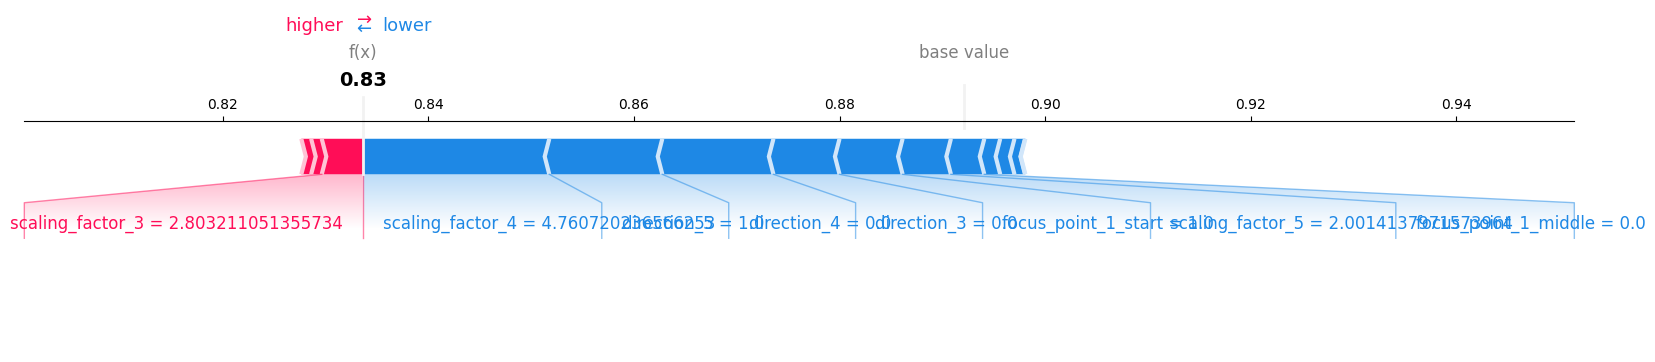

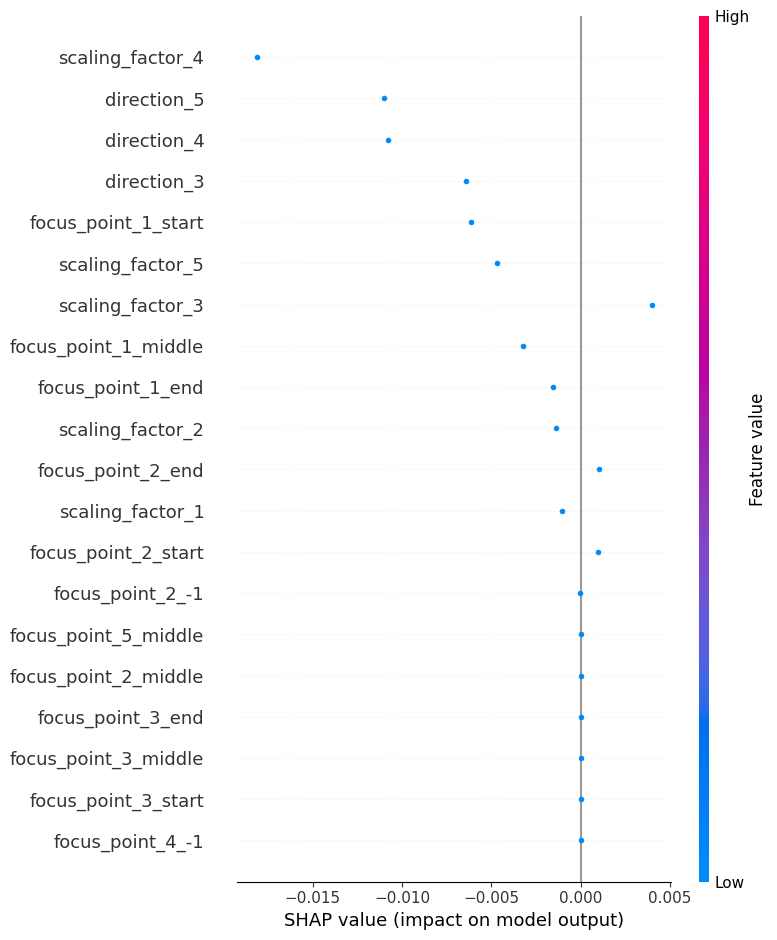

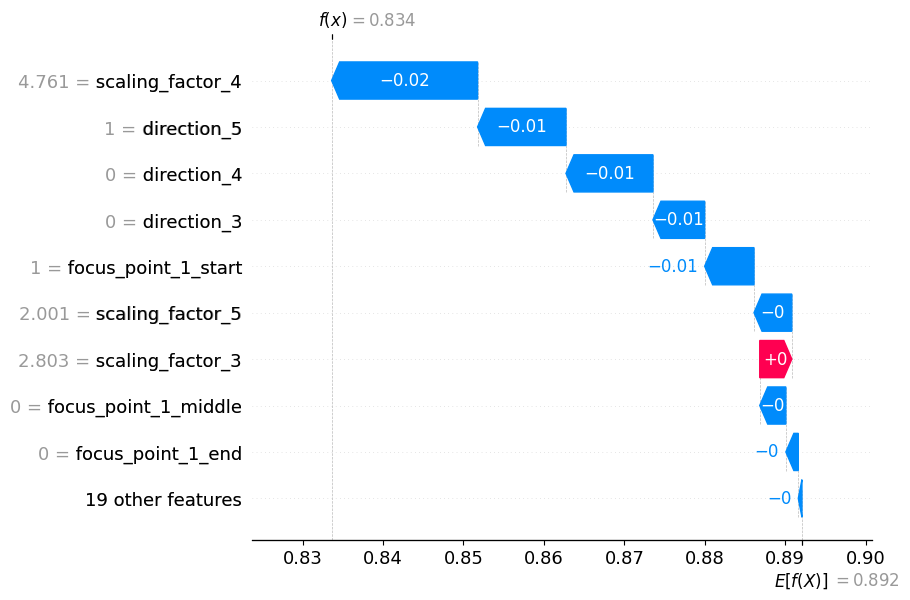

                      SHAP value
scaling_factor_1       -0.001024
direction_1             0.000000
scaling_factor_2       -0.001386
direction_2             0.000000
scaling_factor_3        0.003989
direction_3            -0.006429
scaling_factor_4       -0.018150
direction_4            -0.010814
scaling_factor_5       -0.004700
direction_5            -0.010996
focus_point_1_end      -0.001547
focus_point_1_middle   -0.003250
focus_point_1_start    -0.006138
focus_point_2_-1       -0.000030
focus_point_2_end       0.001030
focus_point_2_middle    0.000000
focus_point_2_start     0.000957
focus_point_3_end       0.000000
focus_point_3_middle    0.000000
focus_point_3_start     0.000000
focus_point_4_-1        0.000000
focus_point_4_end       0.000000
focus_point_4_middle    0.000000
focus_point_4_start     0.000000
focus_point_5_-1        0.000000
focus_point_5_end       0.000000
focus_point_5_middle    0.000000
focus_point_5_start     0.000000
SHAP value: scaling_factor_1       -0.00102

In [59]:
import shap
import matplotlib.pyplot as plt
import pandas as pd

# Zakładając, że masz już wygenerowane shap_values i encoded_df

# Wykres siły oddziaływania (Force Plot)
shap.force_plot(
    shap_values.base_values[0], 
    shap_values.values[0], 
    shap_values.data[0],
    feature_names=encoded_df.columns,
    matplotlib=True
)
plt.show()

# Wykres wartości cech (Summary Plot)
shap.summary_plot(shap_values.values, shap_values.data, feature_names=encoded_df.columns)

# Wykres wartości cech z rozkładem (Summary Plot with Distribution)
#shap.summary_plot(shap_values, encoded_df)

# Wykres wartości cech dla pojedynczego przykładu (Waterfall Plot)
shap.plots.waterfall(shap_values[0])

# Wyciąganie wartości SHAP dla każdej kolumny
shap_values_mean = shap_values.values.mean(axis=0)  # Średnie wartości SHAP dla każdej cechy
shap_values_df = pd.DataFrame(shap_values_mean, index=encoded_df.columns, columns=["SHAP value"])
print(shap_values_df)


In [60]:
shap_values_df

,SHAP value
scaling_factor_1,-0.001024
direction_1,0.000000
scaling_factor_2,-0.001386
direction_2,0.000000
scaling_factor_3,0.003989
direction_3,-0.006429
scaling_factor_4,-0.018150
direction_4,-0.010814
scaling_factor_5,-0.004700
direction_5,-0.010996


In [99]:
operations = df_operations.iloc[[2]]

In [100]:
# Tworzenie słownika operacji
operation_dict = {}

# Iteracja po df_operations
for col in df_operations.columns:
    index = df_operations.at[2, col]  # Pobierz wartość index dla każdej operacji
    operation_suffix = col.split('_')[1]
    if index not in operation_dict:
        operation_dict[index] = {}

    # Filtracja shap_values_df na podstawie numeru operacji
    related_features = shap_values_df.loc[shap_values_df.index.str.contains(f"_{operation_suffix}")]
    
    # Debugowanie
    print(f"Operation: {col}, Index: {index}, Suffix: {operation_suffix}")
    print(f"Related features: {related_features.index.tolist()}")

    for feature in related_features.index:
        operation_dict[index][feature] = shap_values_df.at[feature, 'SHAP value']

# Wyświetlanie wynikowego słownika
print(operation_dict)

Operation: operation_1, Index: 3, Suffix: 1
Related features: ['scaling_factor_1', 'direction_1', 'focus_point_1_end', 'focus_point_1_middle', 'focus_point_1_start']
Operation: operation_2, Index: 3, Suffix: 2
Related features: ['scaling_factor_2', 'direction_2', 'focus_point_2_-1', 'focus_point_2_end', 'focus_point_2_middle', 'focus_point_2_start']
Operation: operation_3, Index: 2, Suffix: 3
Related features: ['scaling_factor_3', 'direction_3', 'focus_point_3_end', 'focus_point_3_middle', 'focus_point_3_start']
Operation: operation_4, Index: 2, Suffix: 4
Related features: ['scaling_factor_4', 'direction_4', 'focus_point_4_-1', 'focus_point_4_end', 'focus_point_4_middle', 'focus_point_4_start']
Operation: operation_5, Index: 2, Suffix: 5
Related features: ['scaling_factor_5', 'direction_5', 'focus_point_5_-1', 'focus_point_5_end', 'focus_point_5_middle', 'focus_point_5_start']
{3: {'scaling_factor_1': -0.0010241130211682548, 'direction_1': 0.0, 'focus_point_1_end': -0.00154744478278255

In [113]:
# full loop

operation_dict = {}

for i in range(len(encoded_df)):

    print(f"processing row {i}")
    
    def predict_wrapper(encoded_df):
        predictions = []
        print(f"to process:{len(encoded_df)}")
        for j in range(len(encoded_df)):
            pred = predict(encoded_df.iloc[[j]], i)
            #print(f"pred: {pred}")
            predictions.append(pred)
        return np.array(predictions)
  
    explainer = shap.Explainer(predict_wrapper, encoded_df)
    
    shap_values = explainer(encoded_df.iloc[[i]])
    print(shap_values)

    shap_values_df = pd.DataFrame(shap_values.values.T, index=encoded_df.columns, columns=["SHAP value"])

    operations = df_operations.iloc[[i]]
    
    for col in df_operations.columns:
        index = df_operations.at[i, col]  # Pobierz wartość index dla każdej operacji
        operation_suffix = col.split('_')[1]
        if index not in operation_dict:
            operation_dict[index] = {}
    
        # Filtracja shap_values_df na podstawie numeru operacji
        related_features = shap_values_df.loc[shap_values_df.index.str.contains(f"_{operation_suffix}")]
        
        # Debugowanie
        print(f"Operation: {col}, Index: {index}, Suffix: {operation_suffix}")
        print(f"Related features: {related_features.index.tolist()}")
    
        for feature in related_features.index:
            operation_dict[index][feature] = shap_values_df.at[feature, 'SHAP value']
    
    # Wyświetlanie wynikowego słownika
    print(operation_dict)


    

processing row 0
to process:337
to process:337
to process:337
to process:337
to process:337
to process:337
to process:337
to process:337


PermutationExplainer explainer: 2it [01:20, 80.80s/it]                                                                          


.values =
array([[ 2.63465210e-02,  0.00000000e+00, -5.93827975e-04,
         5.98628750e-03,  5.27913027e-03, -7.62056006e-05,
         1.12109244e-03, -1.90762146e-03,  6.48160041e-03,
        -1.03229030e-03,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00]])

.base_values =
array([0.12729687])

.data =
array([[0.40196875, 0.        , 2.35588051, 0.        , 4.71671103,
        1.        , 2.62326128, 2.        , 4.48121498, 2.        ,
        1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 1.        ]])
O

PermutationExplainer explainer: 2it [01:22, 82.45s/it]                                                                          


.values =
array([[ 7.59497660e-04, -3.63600929e-03,  1.07134216e-02,
         3.61446762e-03,  1.65632961e-03,  0.00000000e+00,
         1.32934364e-02,  9.03694347e-03,  1.10685502e-02,
         1.43945856e-03,  0.00000000e+00,  1.40969883e-04,
        -1.27972051e-04,  5.92885375e-05,  1.74095011e-03,
         0.00000000e+00, -1.23051466e-03,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.18677508e-04,  1.78727980e-03,  0.00000000e+00,
         6.61874018e-04]])

.base_values =
array([0.33054398])

.data =
array([[2.66002087, 2.        , 4.88385277, 0.        , 2.31399266,
        2.        , 4.67268202, 0.        , 1.82410293, 1.        ,
        0.        , 0.        , 1.        , 0.        , 1.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        1.        , 0.        , 0.        ]])
O

PermutationExplainer explainer: 2it [01:23, 83.79s/it]                                                                          


.values =
array([[ 1.08871719e-03,  0.00000000e+00,  1.27085153e-03,
         0.00000000e+00, -2.60149350e-03,  8.72431871e-03,
         1.48347569e-02,  1.22183497e-02,  3.60795700e-03,
         1.00708087e-02,  1.66487024e-03,  3.71542099e-03,
         3.95598424e-03,  3.92628990e-04,  7.79041456e-05,
         0.00000000e+00, -5.33831122e-04,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00]])

.base_values =
array([0.1079107])

.data =
array([[1.71138888, 2.        , 2.15596597, 0.        , 2.80321105,
        0.        , 4.76072024, 0.        , 2.0014138 , 1.        ,
        0.        , 0.        , 1.        , 0.        , 1.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        ]])
Op

PermutationExplainer explainer: 2it [01:16, 76.40s/it]                                                                          


.values =
array([[-0.00216349,  0.        ,  0.05328795, -0.00867222, -0.00706374,
         0.        , -0.00644007,  0.        ,  0.00661176,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ]])

.base_values =
array([0.49820453])

.data =
array([[2.14550257, 0.        , 4.34657509, 0.        , 2.13095192,
        2.        , 1.8618915 , 1.        , 2.27293643, 2.        ,
        0.        , 1.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 1.        , 0.        ]])
Operation: operation_1, Index: 4, Suffix: 1
Related features: ['scaling_factor_1', 'direction_1', 'focus_point_1_end', 'focus_point_1_middle', 'f

PermutationExplainer explainer: 2it [01:21, 81.64s/it]                                                                          


.values =
array([[-6.70449131e-03,  1.25295196e-03,  1.62505278e-02,
         0.00000000e+00, -3.49818972e-03,  1.13229583e-04,
         2.37706632e-02, -1.69230737e-03,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -1.08768006e-05,
         5.83345216e-04, -5.64785106e-05,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00]])

.base_values =
array([0.51258871])

.data =
array([[ 4.87370429,  0.        ,  2.36356793,  2.        ,  1.97043383,
         1.        ,  1.97256798,  0.        , -1.        , -1.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  1.        ,
         0.        ,  

PermutationExplainer explainer: 2it [01:21, 81.74s/it]                                                                          


.values =
array([[ 6.94875802e-04,  7.86226084e-04,  5.16818075e-03,
         8.54845415e-06, -1.35784208e-03,  8.03789505e-03,
        -4.96310792e-02,  0.00000000e+00,  2.72399378e-02,
         5.31173664e-02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00]])

.base_values =
array([0.39793467])

.data =
array([[2.3204738 , 0.        , 3.69830921, 0.        , 4.46914565,
        0.        , 1.15106945, 2.        , 0.40674926, 2.        ,
        0.        , 1.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ,
        1.        , 0.        , 0.        ]])
O

PermutationExplainer explainer: 2it [01:16, 76.94s/it]                                                                          


.values =
array([[ 5.51098718e-02,  1.17709990e-02,  6.09367327e-02,
        -1.00462955e-02, -3.42679763e-03,  0.00000000e+00,
         1.72356539e-02, -4.70256875e-03,  2.35618861e-02,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  6.32934974e-04,
         1.94031870e-03,  0.00000000e+00, -1.58831243e-06,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00]])

.base_values =
array([0.36183628])

.data =
array([[4.69445733, 0.        , 4.91537593, 1.        , 2.30438046,
        2.        , 4.95244   , 0.        , 2.12948679, 0.        ,
        0.        , 1.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.        ]])
O

PermutationExplainer explainer: 2it [01:23, 83.04s/it]                                                                          


.values =
array([[-1.86641208e-03,  1.59865130e-03,  1.18847275e-01,
         2.65158265e-02, -1.20523416e-05,  1.89798220e-03,
         5.28185663e-03,  1.20172796e-02,  4.73194198e-03,
         4.99840799e-03,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  7.99169715e-04,
         3.52686529e-04,  8.76050677e-04,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00]])

.base_values =
array([0.38927029])

.data =
array([[2.71598568, 0.        , 0.29850154, 2.        , 2.97528605,
        2.        , 3.93618583, 1.        , 4.47462812, 1.        ,
        1.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 1.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        ]])
O

PermutationExplainer explainer: 2it [01:28, 88.79s/it]                                                                          


.values =
array([[ 0.01302238,  0.00544928,  0.0066377 ,  0.00250759, -0.0002184 ,
         0.        ,  0.00205575,  0.        ,  0.0125161 ,  0.00886299,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.00421681,  0.0098251 , -0.00142769,
         0.00049342,  0.00126949,  0.        , -0.00147809,  0.        ,
         0.        ,  0.        ,  0.        ]])

.base_values =
array([0.05193101])

.data =
array([[4.41684651, 0.        , 3.76666789, 0.        , 2.42015792,
        0.        , 1.91799416, 0.        , 3.52968601, 1.        ,
        1.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        ]])
Operation: operation_1, Index: 2, Suffix: 1
Related features: ['scaling_factor_1', 'direction_1', 'focus_point_1_end', 'focus_point_1_middle', 'f

PermutationExplainer explainer: 2it [01:17, 77.71s/it]                                                                          


.values =
array([[ 0.01790324,  0.        ,  0.02852748, -0.0040231 ,  0.00601781,
         0.0074234 ,  0.01174081,  0.00330615,  0.02614839,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ]])

.base_values =
array([0.55446896])

.data =
array([[2.38274257, 1.        , 1.92726276, 0.        , 4.11936417,
        1.        , 3.67152323, 1.        , 2.3146372 , 2.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        1.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 1.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        ]])
Operation: operation_1, Index: 4, Suffix: 1
Related features: ['scaling_factor_1', 'direction_1', 'focus_point_1_end', 'focus_point_1_middle', 'f

PermutationExplainer explainer: 2it [01:27, 87.05s/it]                                                                          

.values =
array([[-0.00020469,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.0020081 ,  0.00401173,  0.00069876,  0.        ,  0.        ,
         0.        ,  0.        ,  0.00349943, -0.00161845,  0.00811817,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ]])

.base_values =
array([0.13424167])

.data =
array([[ 2.3210299 ,  0.        , -1.        , -1.        ,  2.32190477,
         0.        , -1.        , -1.        , -1.        , -1.        ,
         0.        ,  1.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ]])
Operation: operation_1, Index: 3, Suffix: 1
Related features: ['scaling_factor_1', 'direction_1', 'focus_point_1_end'

In [114]:
print(f"final operations_dict: {operation_dict}")

final operations_dict: {4: {'scaling_factor_1': 0.01790323798605961, 'direction_1': 0.0, 'focus_point_1_end': 0.0, 'focus_point_1_middle': 0.0, 'focus_point_1_start': 0.0, 'scaling_factor_3': -0.0034267976285613233, 'direction_3': 0.0, 'focus_point_3_end': 0.0, 'focus_point_3_middle': 0.0, 'focus_point_3_start': 0.0, 'scaling_factor_4': -0.049631079211228724, 'direction_4': 0.0, 'focus_point_4_-1': 0.0, 'focus_point_4_end': 0.0, 'focus_point_4_middle': 0.0, 'focus_point_4_start': 0.0, 'scaling_factor_5': 0.026148390617162162, 'direction_5': 0.0, 'focus_point_5_-1': 0.0, 'focus_point_5_end': 0.0, 'focus_point_5_middle': 0.0, 'focus_point_5_start': 0.0, 'scaling_factor_2': 0.016250527758983564, 'direction_2': 0.0, 'focus_point_2_-1': 0.0, 'focus_point_2_end': 0.0, 'focus_point_2_middle': 0.0, 'focus_point_2_start': 0.0}, 2: {'scaling_factor_2': 0.028527475615518424, 'direction_2': -0.004023098971917598, 'focus_point_2_-1': 0.0, 'focus_point_2_end': 0.0, 'focus_point_2_middle': 0.0, 'focu

In [115]:
# Tworzenie mapy zamiany kluczy
key_mapping = {
    1: 'packet_size_normal',
    2: 'packet_size_uniform',
    3: 'time_jitter_normal',
    4: 'time_jitter_uniform'
}

# Tworzenie nowego słownika z zamienionymi kluczami
new_operation_dict = {}
for key, value in operation_dict.items():
    new_key = key_mapping.get(key, key)  # Zamiana klucza na nową nazwę, jeśli istnieje w key_mapping
    new_operation_dict[new_key] = value

# Wyświetlanie wynikowego słownika
print(new_operation_dict)


{'time_jitter_uniform': {'scaling_factor_1': 0.01790323798605961, 'direction_1': 0.0, 'focus_point_1_end': 0.0, 'focus_point_1_middle': 0.0, 'focus_point_1_start': 0.0, 'scaling_factor_3': -0.0034267976285613233, 'direction_3': 0.0, 'focus_point_3_end': 0.0, 'focus_point_3_middle': 0.0, 'focus_point_3_start': 0.0, 'scaling_factor_4': -0.049631079211228724, 'direction_4': 0.0, 'focus_point_4_-1': 0.0, 'focus_point_4_end': 0.0, 'focus_point_4_middle': 0.0, 'focus_point_4_start': 0.0, 'scaling_factor_5': 0.026148390617162162, 'direction_5': 0.0, 'focus_point_5_-1': 0.0, 'focus_point_5_end': 0.0, 'focus_point_5_middle': 0.0, 'focus_point_5_start': 0.0, 'scaling_factor_2': 0.016250527758983564, 'direction_2': 0.0, 'focus_point_2_-1': 0.0, 'focus_point_2_end': 0.0, 'focus_point_2_middle': 0.0, 'focus_point_2_start': 0.0}, 'packet_size_uniform': {'scaling_factor_2': 0.028527475615518424, 'direction_2': -0.004023098971917598, 'focus_point_2_-1': 0.0, 'focus_point_2_end': 0.0, 'focus_point_2_mi

In [123]:
import pickle; pickle.dump(new_operation_dict, open('../data/metadata/xai_operations_results.pkl', 'wb'))


In [120]:
# Agregowanie wartości w słowniku
aggregated_dict = {}

for key, features in new_operation_dict.items():
    # Tworzenie tymczasowego słownika dla agregacji wartości według prefixu
    temp_dict = {'scaling_factor': 0, 'direction': 0, 'focus_point': 0}
    
    for feature_name, value in features.items():
        # Wyciąganie prefixu cechy i sumowanie wartości odpowiednio
        if feature_name.startswith('scaling_factor'):
            temp_dict['scaling_factor'] += abs(value)
        elif feature_name.startswith('direction'):
            temp_dict['direction'] += abs(value)
        elif feature_name.startswith('focus_point'):
            temp_dict['focus_point'] += abs(value)
    
    # Przypisanie agregowanych danych do głównego słownika
    aggregated_dict[key] = temp_dict

# Wyświetlanie wynikowego słownika
print(aggregated_dict)


{'time_jitter_uniform': {'scaling_factor': 0.11336003320199539, 'direction': 0.0, 'focus_point': 0.0}, 'packet_size_uniform': {'scaling_factor': 0.07182457302510789, 'direction': 0.029064905396751124, 'focus_point': 0.0}, 'packet_size_normal': {'scaling_factor': 0.039789175814410924, 'direction': 0.015290486424363436, 'focus_point': 0.010470275474469593}, 'time_jitter_normal': {'scaling_factor': 0.0035312877929248817, 'direction': 0.0, 'focus_point': 0.024199984147736046}, -1: {'scaling_factor': 0.0, 'direction': 0.0, 'focus_point': 0.0}}


In [121]:
data = aggregated_dict

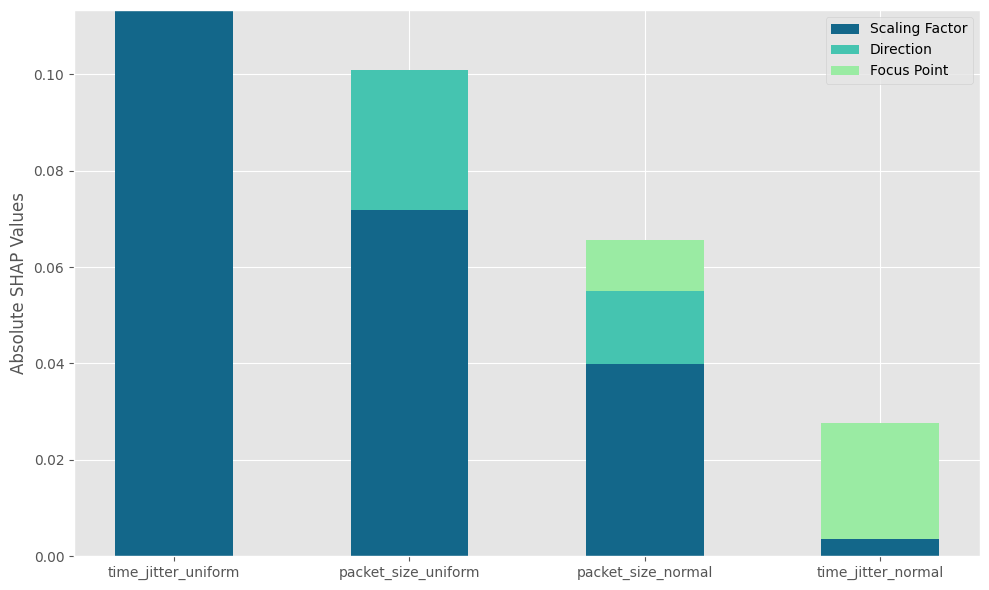

In [134]:
# Usunięcie klucza -1
#data.pop(-1)
# Przygotowanie danych do wykresu
categories = list(data.keys())
scaling_factors = [data[cat]['scaling_factor'] for cat in categories]
directions = [data[cat]['direction'] for cat in categories]
focus_points = [data[cat]['focus_point'] for cat in categories]

x = np.arange(len(categories))  # lokalizacje na osi X
width = 0.5  # szerokość słupka

fig, ax = plt.subplots(figsize=(10, 6))

# Kolory w stylu SHAP
colors = ['#13678A', '#45C4B0', '#9AEBA3']

# Tworzenie stosowanych słupków
p1 = ax.bar(x, scaling_factors, width, label='Scaling Factor', color=colors[0])
p2 = ax.bar(x, directions, width, bottom=scaling_factors, label='Direction', color=colors[1])
p3 = ax.bar(x, focus_points, width, bottom=np.array(scaling_factors) + np.array(directions), label='Focus Point', color=colors[2])

# Dodanie etykiet, tytułu i legendy
ax.set_ylabel('Absolute SHAP Values')
#ax.set_title('Comparison of Parameters by Category')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

# Usunięcie podpisów wartości na słupkach dla czystości wykresu do publikacji
# autolabel(p1)
# autolabel(p2)
# autolabel(p3)

fig.tight_layout()

# Wyświetlenie wykresu
plt.show()